In [1]:
%reload_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16/1.5,9/1.5]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report,\
                            precision_recall_fscore_support,roc_curve, auc ,log_loss, roc_auc_score


from Classification_tools import gain_plot, roc_plot, ks_plot, ks_chart, show_metrics,logit_model, TableLog,lift_plot

from GoodmanKruskal import GKtauDataframe, display_correlation

Load the data and target


Churn data is a sample data used multiple times in IBM cloudpak demos

In [2]:
Target = pd.read_csv("churn.csv")
Data = pd.read_csv("customer.csv")

del Target['ID']
del Data['ID']

In [3]:
Data.head()

,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,F,S,1,38000.00,N,24.393333,23.56,0.0,206.08,0,CC,Budget,Intnl_discount,229.64,3
1,M,M,2,29616.00,N,49.426667,29.78,0.0,45.50,0,CH,FreeLocal,Standard,75.29,2
2,M,M,0,19732.80,N,50.673333,24.81,0.0,22.44,0,CC,FreeLocal,Standard,47.25,3
3,M,S,2,96.33,N,56.473333,26.13,0.0,32.88,1,CC,Budget,Standard,59.01,1
4,F,M,2,52004.80,N,25.140000,5.03,0.0,23.11,0,CH,Budget,Intnl_discount,28.14,1


In [4]:
Data.shape, Target.shape

((2066, 15), (2066, 1))

# Correlation Analysis

In [5]:
categorical_features_names = Data.dtypes[Data.dtypes == 'O'].index
numerical_features_names = Data.dtypes[Data.dtypes == 'float64'].index

Calculate the pearson correlation between numerical features, to remove highly correlated features from the model

In [6]:
pearson_corr = abs(Data[numerical_features_names].corr())

display_correlation(pearson_corr, upper=True).head(5)

,x1,x2,correlation
14,Local,Usage,0.988103
11,LongDistance,Usage,0.331149
10,LongDistance,Local,0.213171
0,EstIncome,Age,0.166682
6,Age,International,0.162794


While people always use Pearson correlation between numerical features, it is usually neglected that some categorical features might also be correlated. One solution is using Goodman and Kruskal’s tau measure. More information here:

https://cran.r-project.org/web/packages/GoodmanKruskal/vignettes/GoodmanKruskal.html

In [7]:
GK_corr = GKtauDataframe(Data[categorical_features_names])
display_correlation(GK_corr, upper=False).head(5)

,x1,x2,correlation
15,Paymethod,Gender,0.056590
16,Paymethod,Status,0.034032
2,Gender,Paymethod,0.032656
7,Status,Paymethod,0.017536
19,Paymethod,LongDistanceBilltype,0.013751


One numerical feature and no categorical features are removed due to high multicolinearity. 

In [8]:
del Data['Local']

Data Transformation

In [9]:
Target = Target.replace({'CHURN': {'T': True, 'F': False}})

In [10]:
df = pd.get_dummies(Data,columns=categorical_features_names,drop_first=True)

Build the logistic regression model

In [11]:
y = Target['CHURN'].values
X = df.values

myscaler = StandardScaler()
X_standardized = myscaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y , train_size=0.80)

In [13]:
model = LogisticRegression(C=10**6,verbose = 0, fit_intercept=True, class_weight="balanced")

model.fit(X_train,y_train);

check the auc on train and test data to make sure the model is valid

In [14]:
print(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]).round(2))
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]).round(2))

0.82
0.79


To check whether the classifier output is affected by changes in the training data, ROC for training and validation data are represented. 

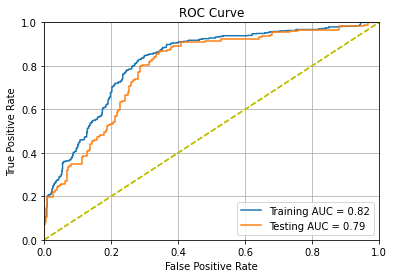

In [15]:
proba_train = model.predict_proba(X_train)[:,1]
proba_test = model.predict_proba(X_test)[:,1]

roc_plot(proba_train, y_train, 'Training')
roc_plot(proba_test, y_test, 'Testing')

The k-s , cumulative gains and lift charts are based on the combined training and testing samples. 

so, calculated the probabilities for all the samples:

In [16]:
proba_all = model.predict_proba(X_standardized)[:,1]


# Kolmogorov-Smirnov Table

it compares the cumulative distribution of events and non-events and the KS is where there is a maximum difference between the two distributions. In simple words, it helps us to understand how well our predictive model is able to discriminate between events and non-events.

Here, predicted probability are divided into 10 parts where first decile should contain highest probability score. Then,  the cumulative percentage  of events and non-events (success / failure) in each decile are calculated and then the difference between these two cumulative distribution are computed. 

If the max K-S is in top deciles and the difference value is larger, the model is considered a better model. 

For example it shows that if the marketing campaign target the top four deciles, the model can cover 66.468% of the responders (4th row of table below).

In [17]:
f= ks_chart(proba_all, y)

display(ks_chart(proba_all, y))

,Decile,Probabilty Ranges,Record Count,Target,NonTarget,% Targets,% NonTargets,% Target Cum,% NonTarget Cum,K-S,Max K-S
9,1,"[0.86, 0.982]",207,180,27,21.403,2.204,21.403,2.204,19.199,
8,2,"[0.767, 0.86]",206,127,79,15.101,6.449,36.504,8.653,27.851,
7,3,"[0.675, 0.767]",206,134,72,15.933,5.878,52.438,14.531,37.907,
6,4,"[0.569, 0.675]",205,126,79,14.982,6.449,67.420,20.980,46.440,
5,5,"[0.446, 0.569]",209,120,89,14.269,7.265,81.688,28.245,53.444,<----
4,6,"[0.356, 0.446]",206,72,134,8.561,10.939,90.250,39.184,51.066,
3,7,"[0.259, 0.356]",207,28,179,3.329,14.612,93.579,53.796,39.783,
2,8,"[0.17, 0.259]",205,15,190,1.784,15.510,95.363,69.306,26.057,
1,9,"[0.106, 0.17]",207,16,191,1.902,15.592,97.265,84.898,12.367,
0,10,"[0.026, 0.106]",208,23,185,2.735,15.102,100.000,100.000,0.000,



# Kolmogorov-Smirnov Plot

It is similar to K-S table, but without splitting the probability scores to 10 deciles. 

1- sort the data by the prediction score,

2 - for every cutoff point [0.0, 1.0] of the sorted dataset (depth), calculate the proportion of targets and non-targets in this depth,

3- For each depth on x-axis, sketch targets/(all targets), nontarget/(all non-targets) on Y-axis. 

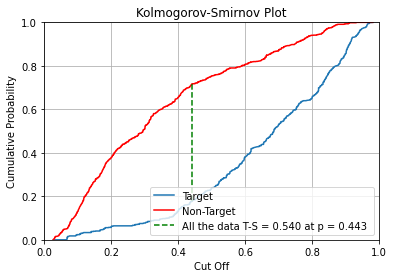

In [18]:
ks_plot(proba_all,y,'All the data')

# ROC and Gain and Lift Charts¶


Gain chart:

Find how much you gain by using your model over a random model for a given fraction of top scored predictions.

1-  order your predictions from highest to lowest 

2- for every percentile you calculate the fraction of true positive observations up to that percentile.

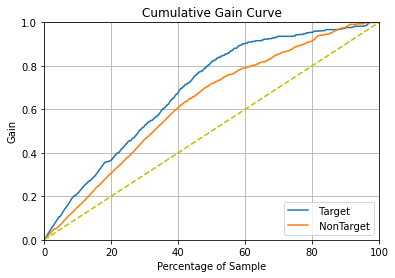

In [19]:
gain_plot(proba_all,y)

Lift Chart:
    
1- order the predictions from highest to lowest

2- for every percentile, we calculate the fraction of true positive observations up to that percentile for our model 
and for the random model,

3- we calculate the ratio of those fractions and plot it.


It tells you how much better your model is than a random model for the given percentile of top scored predictions.

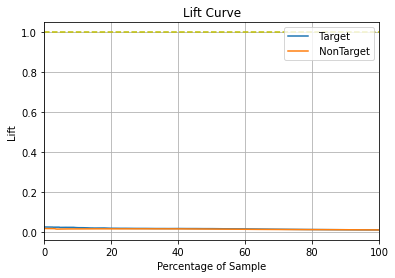

In [20]:
lift_plot(proba_all,y)

More information about these plots and charts see:

https://www.ibm.com/support/knowledgecenter/en/SSLVMB_23.0.0/spss/tutorials/mlp_bankloan_outputtype_02.html

https://towardsdatascience.com/how-to-determine-the-best-model-6b9c584d0db4
    
https://www.saedsayad.com/model_evaluation_c.htm  

https://www.datavedas.com/model-evaluation-classification-models/


# Quasi Elasticity per feature cut

estimate the quasi elasticity using the 


$\eta =\frac {p' - p } { \frac {x' - x}{x}}$


It estimates how much percent point probability of success would change if the value of one predictor ("variable") changes in the amount of "perturbation". The range of "variable" is divided in "L" bin and for each bin, the average quasi-elasticity has been shown. 

In [22]:
X = df.values
X_standardized = myscaler.transform(X)

proba_original = model.predict_proba(X_standardized)[:,1]

In [23]:
variable = "EstIncome"

perturbation = 0.01

L=50

df_perturbed = df.copy()

df_perturbed[variable] = df_perturbed [variable]* (1 + perturbation )

In [24]:
dums_cols = list(df_perturbed.dtypes[df_perturbed.dtypes==object].index)
df_perturbed = pd.get_dummies(df_perturbed,columns=dums_cols,drop_first=True)

X_perturbed = df_perturbed.values
X_perturbed_standardized = myscaler.transform(X_perturbed)

proba_perturbed = model.predict_proba(X_perturbed_standardized)[:,1]

In [25]:
#Estimate the probabilities on perturbed data
Quasi_Elasticity = pd.DataFrame((proba_perturbed-proba_original)/perturbation)
Quasi_Elasticity.columns = ['Quasi_Elasticity']

In [26]:
Quasi_Elasticity = pd.concat ( [Quasi_Elasticity, pd.qcut(df[variable], L, duplicates = 'drop'), 
                 pd.qcut(df[variable],  L, labels =False ,duplicates = 'drop')],axis = 1) 
Quasi_Elasticity.columns = ['Quasi_Elasticity',variable+"_cuts",variable+"_cut_number"]

In [27]:
plt.rcParams["figure.figsize"] = [20,7]

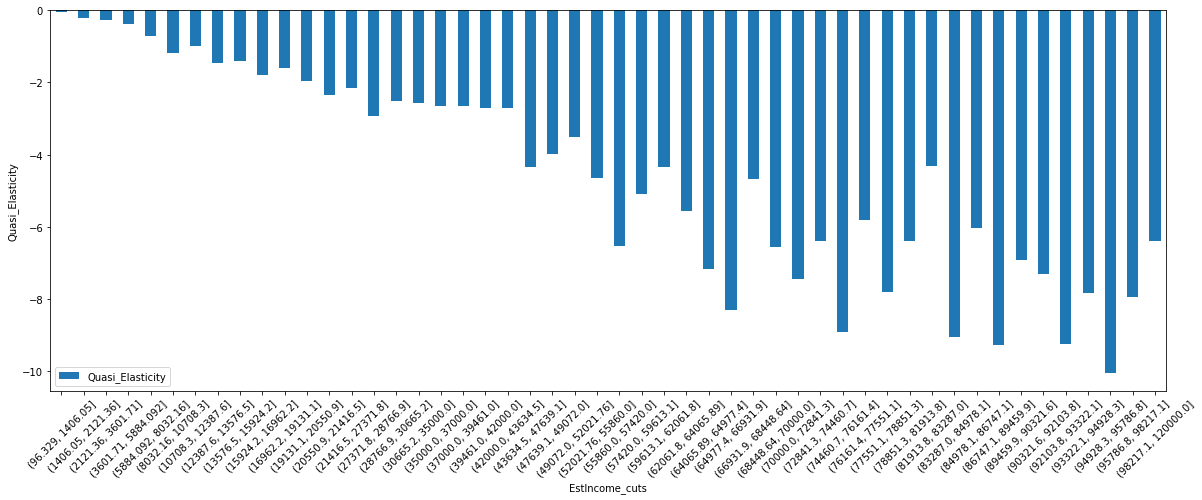

In [28]:
Quasi_Elasticity[['Quasi_Elasticity',variable+"_cuts"]].groupby(variable+"_cuts").sum().plot.bar(rot = 45);
plt.ylabel('Quasi_Elasticity');


The above graph shows that by increasing the income, the sensitivity to income increases. For example for the income of about 20K, 1% increase in income will decrease the churn probability by about point 4% (i.e 40% to 44%   NOT 40*(1+0.04)). 